# Assignment 02 Part 2: Neural Net


# Imports

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random

#custom imports
import csv
import time

#random seed for reproducibility
random.seed(42)

# Functions

In [12]:
#Helper functions
def sigmoid (a, derivative = False):
    """Returns the sigmoid of a, or the derivative respect to o = s(a)"""
    if derivative:
        return a * (1 - a)
    else:
        return (1 / (1 + np.exp(-a)))


def ReLU (a, alpha = 0.1, derivative = False):
    """Leaky rectified linear unit: takes an activation value and returns output.
    Use alpha = 0 for original ReLU, or it returns its derivative respect to a"""
    if derivative:
        out = np.maximum(a * alpha, a) / a
        out[np.isnan(out)] = 0.5
        return out
    else:
        return np.maximum(a * alpha, a)


def MSE(z, derivative = False):
    """Returns Mean Squared Error from error_vector z, or its derivative respect to it."""
    if derivative:
        return z / z.shape[0]
    else:
        return np.sum(z**2, axis=0) / (2 * z.shape[0])

    
def w_initializer(ann):
    """Initializes weight matrix for a neural network object using its specified initializer function.
    The weights of each node in a layer 'k' can be represented in matrix form Wk.
    *Each row contains the weights for one node in layer k.
    *Each column contains the weights on the output of one node in
    the previous layer k − 1.
    Returns a list of weights.
    """
    #one matrix per layer, dims = size,no_inputs
    l_weights = []
        
    v_sizes = [ann.no_inputs, 
               *[l.size for l in ann.layers], 
               ann.no_output_nodes]
    
    for l in range(len(ann.layers) + 1):
        this_dim = (v_sizes[l+1], v_sizes[l]+1)#adds one weight per node for bias (input of 1)
        print('initializing',l)
        print(l,this_dim)
        
        if ann.initializer == 'zero':
            weights_m = np.zeros(this_dim)
            
        elif ann.initializer == 'uni':
            weights_m = np.random.random(this_dim)-0.5 #uniformly distributed rnd values between -0.5 and 0.5
            
        elif ann.initializer == 'xavier':
            weights_m = ((np.random.random(this_dim) * 2) - 1) * np.sqrt(6/(np.sum(this_dim))) #xavier. source = keras documentation
    
        #print(weights_m)
        l_weights.append(weights_m)
    return l_weights

    
def prepare_data(train_filename, test_filename, ones = False):
    """Opens datasets (csv files) and returns X_train, y_train, X_test, y_test arrays 
    with added 1 vector for bias constant"""
    
    #parse data
    with open(train_filename) as csvfile:
        train_data = list(csv.reader(csvfile))

    train_data_arr = np.array(train_data)
    X_train = train_data_arr[:,1:].astype(float)
    if ones:
        X_train = np.hstack((np.ones((X_train.shape[0],1)), X_train))
    y_train = train_data_arr[:,0].astype(float)
    y_train_oh = np.eye(10)[y_train.astype(int)]#one hot encode
    
    #test data
    with open(test_filename) as csvfile:
        test_data = list(csv.reader(csvfile))

    test_data_arr = np.array(test_data)
    X_test = test_data_arr[:,1:].astype(float)
    if ones:
        X_test = np.hstack((np.ones((X_test.shape[0],1)), X_test))
    y_test = test_data_arr[:,0].astype(float)
    y_test_oh = np.eye(10)[y_test.astype(int)]#one hot encode

    #scale data: Useful to prevent activation values explosion and help sigmoid function 
    #work inside its "best zone" (with greater gradient)
    X_train = X_train / 255
    X_test = X_test / 255
    
    return X_train, y_train_oh, X_test, y_test_oh


def smaller_data(x, size):
    return x[0:size]

def test_score(ANN, only_acc = True, test = True):
    #parse data
    X = X_test
    y = y_test
    
    if test == False:
        X = X_train
        y = y_train 
    
    outputs = ANN.predict(X)[-1]
    y_pred = np.argmax(outputs, axis=1).reshape(-1,1)
    y_labels = np.argmax(y, axis=1).reshape(-1,1)
    
    #calculate loss
    error = np.array(y_pred - y_labels)
    loss = np.average(MSE(error))
    
    #calculate stats for each digit
    """accuracy = (TP + TN) / (TP + FP + FN + TN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)"""
    
    stats = {}
    for i in range(10):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        for j,k in zip(y_pred, y_labels): 
            if j == i and k == i:
                TP +=1
            if j == i and k != i:
                FP +=1
            if j != i and k != i:
                TN +=1
            if j != i and k == i:
                FN +=1
        stats[i]=[TP,FP,TN,FN]

    #calculate global accuracy
    TTP = 0
    TFP = 0
    TTN = 0
    TFN = 0
    for v in stats.values():
        TTP += v[0]
        TFP += v[1]
        TTN += v[2]
        TFN += v[3]

    Tacc = (TTP+TTN) / (TTP+TFP+TTN+TFN)
    stats['Tacc'] = Tacc
    
    if only_acc:
        return Tacc, loss
    
    else:
        print('True Positive Rate = {:.4f}'.format(TTP/len(y)))
        print('Average Accuracy = {:.4f}'.format(Tacc))
        for i in range(10):
            print(i)
            print('Accuracy = {:.4f}'.format((stats[i][0] + stats[i][2]) / np.sum(stats[i])))
            print('Precision = {:.4f}'.format((stats[i][0] / (stats[i][0] + stats[i][1]))))
            print('Recall = {:.4f}'.format((stats[i][0] / (stats[i][0] + stats[i][3]))))
        return stats


# Layer Class

In [5]:
class Layer:
    def __init__(self, size = 10, act_func = sigmoid):
        self.size = size
        self.act_func = act_func
        self.weights = np.array(())
        
        
    def forward(self, inp):
        inp = np.hstack((np.ones((inp.shape[0],1)), inp))
        output = np.dot(inp, self.weights.T)
        output = self.act_func(output)
        return output
    
    
    def print_details(self):
        print('size = {}, act_func={}, weights_shape={}'.format(self.size, self.act_func,self.weights.shape))
    
    

# Neural Net Class

In [6]:
class ANN:

    #==========================================#
    # The init method is called when an object #
    # is created. It can be used to initialize #
    # the attributes of the class.             #
    #==========================================#
    def __init__(self, 
                 no_inputs=784,
                 layers = [],
                 no_output_nodes=10,
                 max_iterations=20,
                 learning_rate=0.5, 
                 output_act_func = sigmoid, 
                 initializer = 'xavier', 
                 loss_function = MSE):

        self.no_inputs = no_inputs
        self.layers = layers
        self.no_output_nodes = no_output_nodes
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.output_act_func = output_act_func
        self.initializer = initializer
        self.loss_function = loss_function
        self.compiled = False
        self.history = {'train_accuracy':[], 'train_loss': [], 'test_accuracy':[], 'test_loss': []}
        
        
    def compile_ANN(self):
        self.weights = w_initializer(self)
        self.layers.append(Layer(size = self.no_output_nodes, act_func = self.output_act_func))
        
        for w,l in zip(self.weights, self.layers):
            l.weights = w
        
        self.compiled = True
        return 'OK'
    
    
    #========================================#
    # calculates 1 forward pass for the nn.  #
    #========================================#
    def predict(self, inputs):
        """Takes an inputs matrix and returns ANN's list of each layer's output"""   
        try:
            assert inputs.shape[1] == self.no_inputs
        except:
            print('Wrong input shape, number of inputs is {} but should be {}'.format(inputs.shape[1],self.no_inputs))
            return False
        
        try:
            assert self.compiled == True
        except:
            print('NN has not been compiled error. Please compile it before trying to predict.')
            return False
            
        result = inputs
        outputs = [inputs]
        
        for l in self.layers:
            result = l.forward(result)
            outputs.append(result)
            
        return outputs
    

    
    #===============================#
    # Trains the net using labelled #
    # training data.                #
    #===============================#
    def train(self, training_data, labels, batch_size = 32, epochs = 1):
        """Trains ANN weights using mini batches size = batch_size"""
        time_start = time.perf_counter()
        assert len(training_data) == len(labels)
        assert self.compiled == True
        
        print('epochs:')
        for e in range(epochs):
            this_data = np.column_stack((training_data, labels))
            np.random.shuffle(this_data)
            print(e, ' ', end='' )
            accuracy, loss = test_score(self, only_acc = True)
            self.history['test_accuracy'].append(accuracy)
            self.history['test_loss'].append(loss)
            
            for mb in range(training_data.shape[0] // batch_size): 
                weights_update = {}
                deltas = {}
            
                #Predict (forward phase)
                slice_start = mb * batch_size
                slice_end = slice_start + batch_size
                outputs = self.predict(this_data[slice_start:slice_end,0:784])
                exp_out = this_data[slice_start:slice_end,784:]
                
                #backwards phase
                
                for i in range(1,len(self.layers)+1):
                    l =  len(self.layers) - i   
                    if l == len(self.layers)-1:
                        delta = (outputs[-i] - exp_out) / outputs[-i].shape[0]
                        deltas[l]=delta
                        prev_output = np.hstack((np.ones((outputs[-i-1].shape[0],1)), outputs[-i-1]))
                        weights_update[l] = np.dot(delta.T, prev_output)
                        #print('weights_update[l] shape', weights_update[l].shape)
                        
                    else:
                        delta = np.dot(delta, self.weights[l+1][:,1:])
                        this_output_i=outputs[-i]
                        delta = np.multiply(delta, self.layers[l].act_func(this_output_i, derivative = True))
                        deltas[l]=delta
                        prev_output = np.hstack((np.ones((outputs[-i-1].shape[0],1)), outputs[-i-1]))
                        weights_update[l] = np.dot(delta.T, prev_output)
                        #print('weights_update[l] shape', weights_update[l].shape)
                
                #print('updating weights')
                for l in range(len(self.layers)):
                    #print('self.weights [l] shape', self.weights[l].shape)
                    #print('weight updates [l]shape', weights_update[l].shape)
                    self.weights[l] -= weights_update[l] * self.learning_rate
        
        time_end = time.perf_counter()
        total_time = time_end - time_start
        return total_time

    
    #=========================================#
    # Tests the prediction on each element of #
    # the testing data. Prints the precision, #
    # recall, and accuracy.                   #
    #=========================================#
    
    def report(self):
        """Creates a report on the neural net performance."""
    
        #learning charts
        fig, axs = plt.subplots(2, 1)
        fig.suptitle('Learning History', y = 2.35, fontsize=19, fontweight='bold')
        plt.subplots_adjust(left=0, right=2, top=2, bottom= 0, wspace= 0.5, hspace=1)
        axs[0].plot(self.history['test_accuracy'], c = 'blue', label='test')
        axs[0].set_title('Test Accuracy Evolution')
        axs[0].legend(loc='best')
        
        axs[1].plot(self.history['test_loss'], c = 'blue', label='test')
        axs[1].set_title('Test Loss Evolution')
        axs[1].legend(loc='best')
        
        plt.show()
        
        #full statistics (accuracy, precision and recall for each digit)
        test_score(self, only_acc = False)
              
        #Example of misclassifications
        #Showing 16 error examples in Test set
        X,y = X_test, y_test
        assert len(X) == len(y)
        outputs = self.predict(X)[-1]
        y_pred = np.argmax(outputs, axis=1).reshape(-1,1)
        y_labels = np.argmax(y, axis=1).reshape(-1,1)
        y_correct = (y_pred == y_labels)
        y_wrong = (y_pred != y_labels)
        
        this_plot = plt.figure(figsize=[10, 15])
        fig, axs = plt.subplots(4, 4)
        fig.suptitle('Prediction error examples', y = 2.35, fontsize=19, fontweight='bold')
        plt.subplots_adjust(left=0, right=2, top=2, bottom= 0, wspace= 0.5, hspace=1)
        
        err_ind = np.where(y_wrong == True)
        for i in range(4):
            for j in range(4):
                this_index = err_ind[0][4*i+j]
                this_sample = X[this_index,:].reshape(28,28)
                axs[i, j].imshow(this_sample)
                axs[i, j].set_title('Pred = ' + str(y_pred[this_index]) +'\n'+ 'Label = '+str(y_labels[this_index]), fontsize = 12, loc = 'left', y=1.1)
        plt.show()
        
        return True
        

# Main method

## 2.1 Loading data

In [7]:
X_train, y_train, X_test, y_test = prepare_data('mnist_train.csv', 'mnist_test.csv')

## 2.2 Creating and initializing an instance of Neural Net using sigmoid activations

In [8]:
# Creating Layer instances
nn12l1 = Layer(size=50, act_func = sigmoid)
nn12l2 = Layer(size=50, act_func = sigmoid)
nn12l3 = Layer(size=50, act_func = sigmoid)
nn12l4 = Layer(size=50, act_func = sigmoid)

# Creating Net Instance
nn12 = ANN(no_inputs = 784,
          layers = [nn12l1, nn12l2, nn12l3, nn12l4],
          no_output_nodes = 10,
          max_iterations = 10,
          learning_rate = 0.004,
          output_act_func = sigmoid,
          initializer = 'uni',
          loss_function = MSE)

# Initializing Net Instance
nn12.compile_ANN()

initializing 0
0 (50, 785)
initializing 1
1 (50, 51)
initializing 2
2 (50, 51)
initializing 3
3 (50, 51)
initializing 4
4 (10, 51)


'OK'

In [9]:
#Check NN details
for l in nn12.layers:
    l.print_details()

size = 50, act_func=<function sigmoid at 0x7fb6a9c0ca60>, weights_shape=(50, 785)
size = 50, act_func=<function sigmoid at 0x7fb6a9c0ca60>, weights_shape=(50, 51)
size = 50, act_func=<function sigmoid at 0x7fb6a9c0ca60>, weights_shape=(50, 51)
size = 50, act_func=<function sigmoid at 0x7fb6a9c0ca60>, weights_shape=(50, 51)
size = 10, act_func=<function sigmoid at 0x7fb6a9c0ca60>, weights_shape=(10, 51)


## 2.3 Training

In [10]:
nn12.train(X_train,y_train, batch_size = 30, epochs = 50)

epochs:
0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  

107.99169750000001

## 2.4 Testing

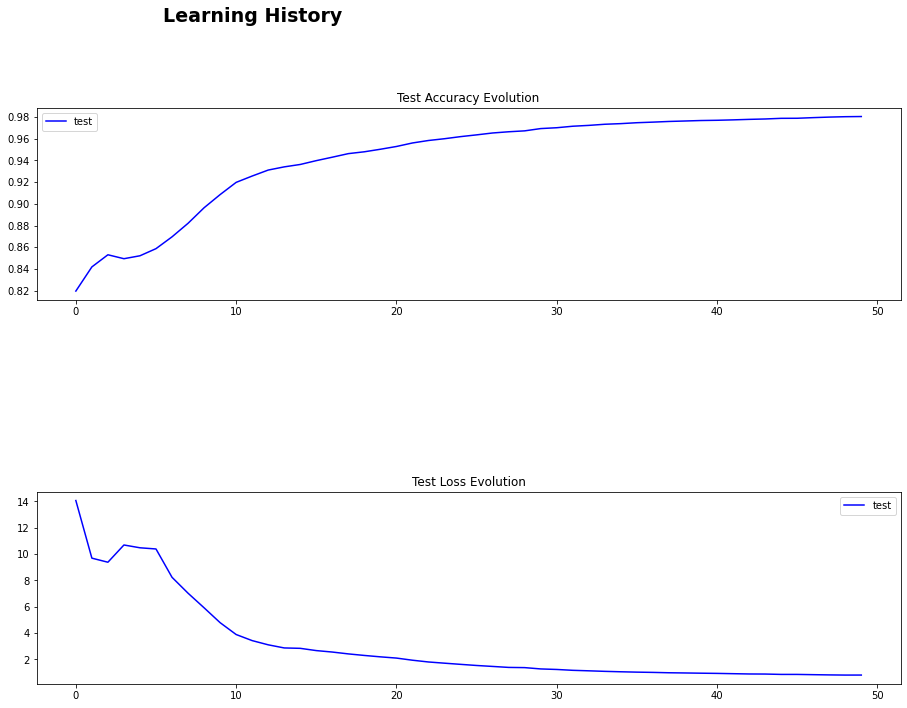

True Positive Rate = 0.9044
Average Accuracy = 0.9809
0
Accuracy = 0.9903
Precision = 0.9282
Recall = 0.9765
1
Accuracy = 0.9920
Precision = 0.9575
Recall = 0.9727
2
Accuracy = 0.9789
Precision = 0.9117
Recall = 0.8808
3
Accuracy = 0.9767
Precision = 0.8776
Recall = 0.8941
4
Accuracy = 0.9797
Precision = 0.8883
Recall = 0.9073
5
Accuracy = 0.9742
Precision = 0.8783
Recall = 0.8251
6
Accuracy = 0.9852
Precision = 0.9150
Recall = 0.9322
7
Accuracy = 0.9824
Precision = 0.9251
Recall = 0.9018
8
Accuracy = 0.9779
Precision = 0.8910
Recall = 0.8809
9
Accuracy = 0.9715
Precision = 0.8591
Recall = 0.8583


<Figure size 720x1080 with 0 Axes>

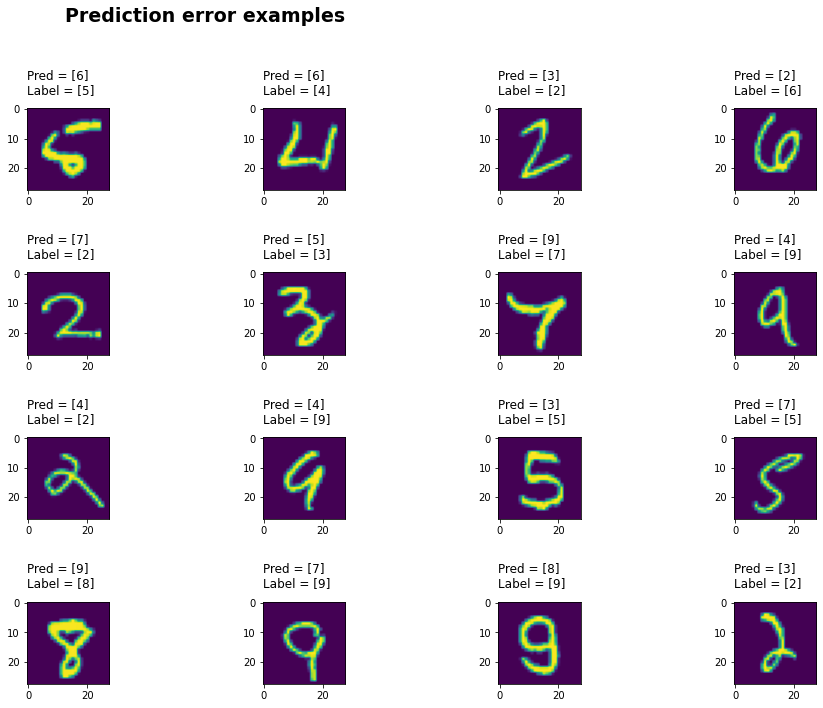

True

In [13]:
nn12.report()

## Comments

This Neural net with 4 hidden layers took 108 seconds to train 50 epochs. In contrast, the "ensemble of perceptrons" trained all 10 separate perceptrons for 500 epochs each in around 73 seconds.  
Even considering this 'overkill' number of epochs, the perceptrons trained much faster.  
Resuts are very similar but better for the neural net (True positive rate of 90.44% vs 89.17% for the perceptron ensemble). For example, the perceptron got 98.93% accuracy for digit 0 and nn12 got 99.03%.
The optimization process was arduous, mainly because a couple of insidious bugs. Some test nets needed a learning rate of 2 to start learning!  Others had to train for 500 epochs to converge :-(  
Once the training was working allright, I tried learning rates from 0.0001 to 0.5, tried configurations with 2, 3 and 4 hidden layers (Same size and decreasing sizes), also tried several minibatch sizes including 1 (online) and 60.000 (Batch).
One surprise was that learning was much better using my 'uni' initializer compared to 'xavier'. It might be that I did not implement it right, or that this particular task worked better with my initializer. The idea of initializing values between -0.5 and +0.5 is to focus on the sweet spot of the activation functions (specially sigmoid).
For the perceptron, I did not really test convergence speed, since it was so fast in vectorized form, it was an easy decision to train for a lot of epochs.

#### A note regarding accuracy:  
I started calculating accuracy as **number of correct classifications / total samples**.  
Using this measure ("True Positive rate"), this neural net do not really make the 95% threshold (nn12 gets around 90%).  
But when you check individual accuracy for each digit, all of them are well above 97%! How can this be? Well the answer lies in the fact that each digit prediction has a lot of true negatives! (that are 'shared' among them).  

So I settled on also using this measure of accuracy:

**Average accuracy = ( ∑TP + ∑TN ) / ( ∑TP + ∑FP + ∑TN + ∑FN )** (as seen on test_score function).  



 

  
    
    

## 2.2 Creating and initializing an instance of Neural Net using ReLU activations

In [14]:
# Creating Layer instances
nn13l1 = Layer(size=50, act_func = ReLU)
nn13l2 = Layer(size=50, act_func = ReLU)
nn13l3 = Layer(size=50, act_func = ReLU)
nn13l4 = Layer(size=50, act_func = ReLU)

# Creating Net Instance
nn13 = ANN(no_inputs = 784,
          layers = [nn13l1, nn13l2, nn13l3, nn13l4],
          no_output_nodes = 10,
          max_iterations = 10,
          learning_rate = 0.004,
          output_act_func = sigmoid,
          initializer = 'uni',
          loss_function = MSE)

# Initializing Net Instance
nn13.compile_ANN()

initializing 0
0 (50, 785)
initializing 1
1 (50, 51)
initializing 2
2 (50, 51)
initializing 3
3 (50, 51)
initializing 4
4 (10, 51)


'OK'

In [15]:
#Check NN details
for l in nn13.layers:
    l.print_details()

size = 50, act_func=<function ReLU at 0x7fb6c8427670>, weights_shape=(50, 785)
size = 50, act_func=<function ReLU at 0x7fb6c8427670>, weights_shape=(50, 51)
size = 50, act_func=<function ReLU at 0x7fb6c8427670>, weights_shape=(50, 51)
size = 50, act_func=<function ReLU at 0x7fb6c8427670>, weights_shape=(50, 51)
size = 10, act_func=<function sigmoid at 0x7fb6c84275e0>, weights_shape=(10, 51)


## Training

In [16]:
nn13.train(X_train,y_train, batch_size = 30, epochs = 50)

epochs:
0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  

119.25198683400004

## Testing

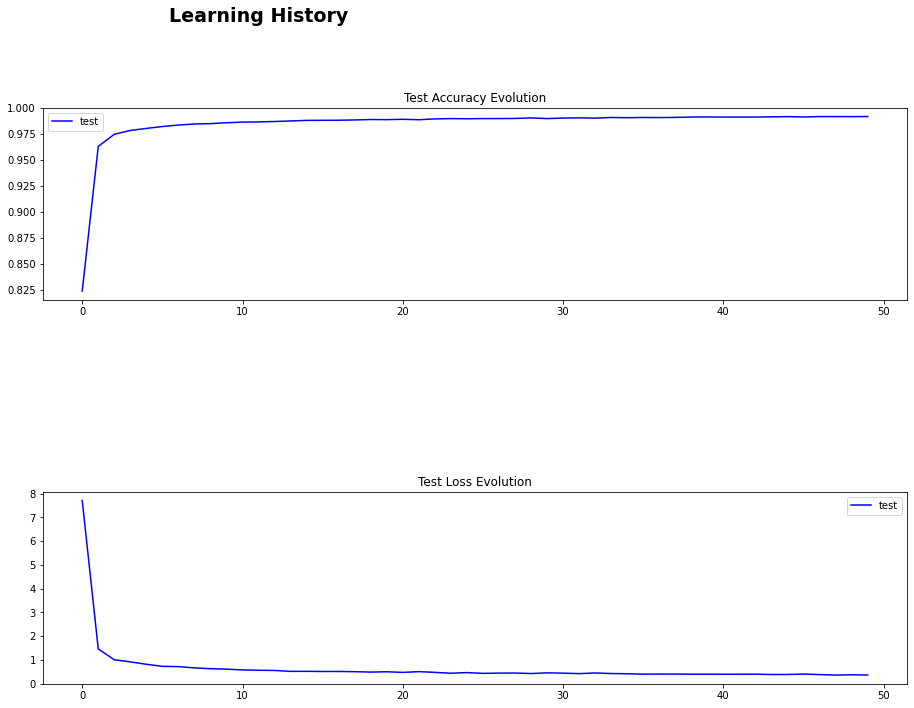

True Positive Rate = 0.9597
Average Accuracy = 0.9919
0
Accuracy = 0.9952
Precision = 0.9688
Recall = 0.9827
1
Accuracy = 0.9959
Precision = 0.9765
Recall = 0.9877
2
Accuracy = 0.9905
Precision = 0.9699
Recall = 0.9370
3
Accuracy = 0.9885
Precision = 0.9291
Recall = 0.9594
4
Accuracy = 0.9932
Precision = 0.9682
Recall = 0.9623
5
Accuracy = 0.9908
Precision = 0.9630
Recall = 0.9327
6
Accuracy = 0.9934
Precision = 0.9675
Recall = 0.9635
7
Accuracy = 0.9918
Precision = 0.9488
Recall = 0.9728
8
Accuracy = 0.9897
Precision = 0.9467
Recall = 0.9476
9
Accuracy = 0.9904
Precision = 0.9588
Recall = 0.9455


<Figure size 720x1080 with 0 Axes>

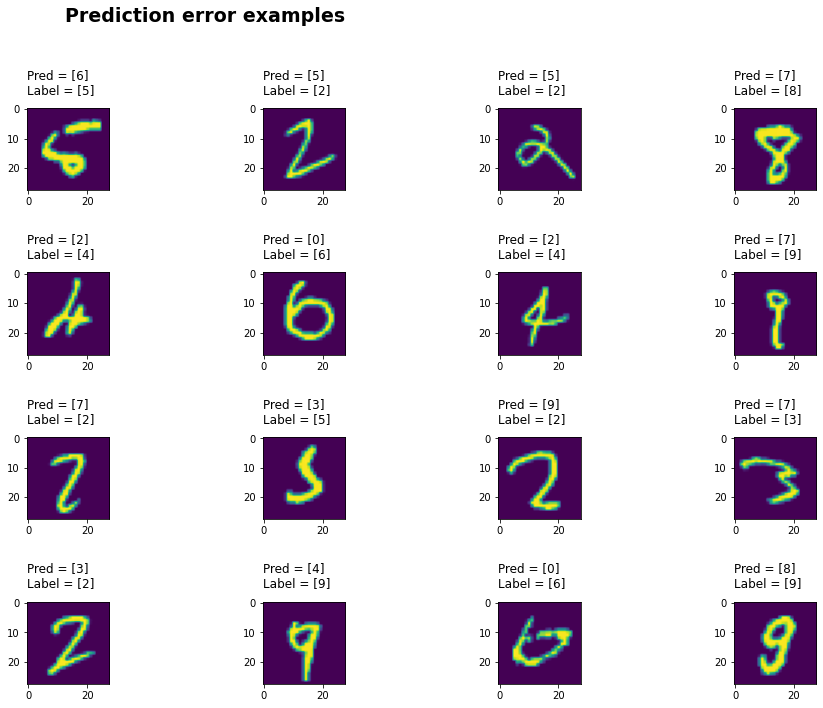

True

In [17]:
nn13.report()

## Comments

Wow! ReLU* delivered on every measure:  
It trained slower than sigmoid: 119 seconds vs 108 seconds for 50 epochs. BUT! It could train for much less epochs because it converged sooner. So in practice it is faster.   
It learned better: True positive rate of 95.97% vs 90.44% (99.19% and 98.09% average accuracy).  
It converged sooner: It started plateauing before 5 epochs, while the sigmoid net did after 30.  
This results were obtained using the same hyperparameters as the sigmoid (nn12) net.  

  
    
      
*I used leaky ReLU with a 0.1 leak.

#### Note regarding train and test dataset performance:  
During development, I measured both Train and test dataset's performance, and they were strikingly similar everytime. That is why I am showing only test set performance in the Neural nets report.
For the sake of the marking scheme, here is a comparison of train and test datasets performance fon nn13:

In [20]:
#nn13 scores for test dataset
test_score(nn13, only_acc = False, test = True)

True Positive Rate = 0.9597
Average Accuracy = 0.9919
0
Accuracy = 0.9952
Precision = 0.9688
Recall = 0.9827
1
Accuracy = 0.9959
Precision = 0.9765
Recall = 0.9877
2
Accuracy = 0.9905
Precision = 0.9699
Recall = 0.9370
3
Accuracy = 0.9885
Precision = 0.9291
Recall = 0.9594
4
Accuracy = 0.9932
Precision = 0.9682
Recall = 0.9623
5
Accuracy = 0.9908
Precision = 0.9630
Recall = 0.9327
6
Accuracy = 0.9934
Precision = 0.9675
Recall = 0.9635
7
Accuracy = 0.9918
Precision = 0.9488
Recall = 0.9728
8
Accuracy = 0.9897
Precision = 0.9467
Recall = 0.9476
9
Accuracy = 0.9904
Precision = 0.9588
Recall = 0.9455


{0: [963, 31, 8989, 17],
 1: [1121, 27, 8838, 14],
 2: [967, 30, 8938, 65],
 3: [969, 74, 8916, 41],
 4: [945, 31, 8987, 37],
 5: [832, 32, 9076, 60],
 6: [923, 31, 9011, 35],
 7: [1000, 54, 8918, 28],
 8: [923, 52, 8974, 51],
 9: [954, 41, 8950, 55],
 'Tacc': 0.99194}

In [21]:
#nn13 scores for train dataset
test_score(nn13, only_acc = False, test = False)

True Positive Rate = 0.9727
Average Accuracy = 0.9945
0
Accuracy = 0.9971
Precision = 0.9827
Recall = 0.9884
1
Accuracy = 0.9963
Precision = 0.9813
Recall = 0.9864
2
Accuracy = 0.9938
Precision = 0.9846
Recall = 0.9520
3
Accuracy = 0.9920
Precision = 0.9619
Recall = 0.9602
4
Accuracy = 0.9947
Precision = 0.9699
Recall = 0.9760
5
Accuracy = 0.9946
Precision = 0.9738
Recall = 0.9662
6
Accuracy = 0.9968
Precision = 0.9818
Recall = 0.9861
7
Accuracy = 0.9942
Precision = 0.9590
Recall = 0.9866
8
Accuracy = 0.9929
Precision = 0.9566
Recall = 0.9711
9
Accuracy = 0.9929
Precision = 0.9762
Recall = 0.9514


{0: [5854, 103, 53974, 69],
 1: [6650, 127, 53131, 92],
 2: [5672, 89, 53953, 286],
 3: [5887, 233, 53636, 244],
 4: [5702, 177, 53981, 140],
 5: [5238, 141, 54438, 183],
 6: [5836, 108, 53974, 82],
 7: [6181, 264, 53471, 84],
 8: [5682, 258, 53891, 169],
 9: [5660, 138, 53913, 289],
 'Tacc': 0.99454}

nn13 gets 99.45% of average accuracy on the training dataset, vs 99.19% for the test set.  
On train dataset, the worst accuracy is for digit 3 (99.20%) and the same is true for test dataset (98.85%).  
Overall, it is very interesting to see great generalization to the test set considering that, according to my readings, the test set digits were draw by different people!